# VIX Options Chain Analysis

This notebook loads the VIX options chain data, normalises its column names, and computes mid-prices and option deltas using the cleaned schema.

In [14]:
from pathlib import Path
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
from IPython.display import display
from datetime import timedelta

plt.style.use('seaborn-v0_8')

VALUATION_DATE = pd.Timestamp("2025-10-13")
chain_path =  '../data/VIX_65d_Options_ChainData.csv'
underlying_path =  '../data/VIX_65d_Options_UnderlyingData.csv'

chain = pd.read_csv(chain_path)
# Normalise the chain columns by removing excess whitespace and internal spaces.
chain.columns = (
    chain.columns
    .str.strip()
    .str.replace(r"\s+", "", regex=True)
)

chain['CallMid'] = (chain['CallBid'] + chain['CallAsk']) / 2
chain['PutMid'] = (chain['PutBid'] + chain['PutAsk']) / 2

required_columns = {
    'Strike', 'CallBid', 'CallAsk', 'PutBid', 'PutAsk', 'CallIVM', 'PutIVM'
}
# Accept either Expiry or T for the maturity representation.
if {'Expiry', 'T'} & set(chain.columns):
    required_columns.add('Expiry' if 'Expiry' in chain.columns else 'T')
else:
    raise ValueError('Missing required maturity column: expected `Expiry` or `T`.')

missing_columns = sorted(required_columns - set(chain.columns))
if missing_columns:
    raise ValueError(f'Missing required columns after renaming: {missing_columns}')

underlying = pd.read_csv(underlying_path)
underlying.columns = (
    underlying.columns
    .str.strip()
    .str.replace(r"\s+", "", regex=True)
)

chain.head()

,Strike,T,CallBid,CallAsk,CallIVM,CallVolm,CofC,PutBid,PutAsk,PutIVM,PutVolm,CallMid,PutMid
0,13.0,0.1806,7.15,7.25,57.204117,0,0.096836,0.02,0.05,53.865036,61,7.200,0.035
1,13.5,0.1806,6.70,6.75,49.290291,0,0.100560,0.04,0.07,53.761135,0,6.725,0.055
2,14.0,0.1806,6.20,6.35,56.960262,6,0.104285,0.08,0.11,55.268276,1304,6.275,0.095
3,14.5,0.1806,5.80,5.90,56.820499,5,0.108009,0.14,0.18,57.482933,33,5.850,0.160
4,15.0,0.1806,5.35,5.50,59.834236,105,0.111734,0.23,0.27,59.955227,367,5.425,0.250


In [15]:
merged = chain.merge(underlying, on='T', how='left', suffixes=('', '_underlying'))

unique_tenors = merged['T'].unique()
tenor_map = dict(zip(sorted(unique_tenors), ['UXZ5', 'UXF6']))
merged['Expiry'] = merged['T'].map(tenor_map)

tenor_calendar = []
for tenor in sorted(unique_tenors):
    days = int(round(tenor * 365))
    expiry_date = VALUATION_DATE + timedelta(days=days)
    tenor_calendar.append({'T': tenor, 'Calendar Days': days, 'Expiry (Approx)': expiry_date.date()})

pd.DataFrame(tenor_calendar)

,T,Calendar Days,Expiry (Approx)
0,0.1806,66,2025-12-18
1,0.2778,101,2026-01-22


In [16]:
# Helper functions for the normal CDF and Black-76 deltas.
def norm_cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))


def black76_call_delta(forward, strike, vol, tau, r=0.0, q=0.0):
    if vol <= 0 or tau <= 0 or forward <= 0 or strike <= 0:
        return float('nan')
    d1 = (math.log(forward / strike) + (q - r + 0.5 * vol ** 2) * tau) / (vol * math.sqrt(tau))
    return math.exp(-q * tau) * norm_cdf(d1)


def black76_put_delta(forward, strike, vol, tau, r=0.0, q=0.0):
    call_delta = black76_call_delta(forward, strike, vol, tau, r=r, q=q)
    if math.isnan(call_delta):
        return float('nan')
    return call_delta - math.exp(-q * tau)


forward = float(underlying.loc[0, 'Future'])
r = float(underlying.loc[0, 'r']) if 'r' in underlying.columns else 0.0
q = float(underlying.loc[0, 'q']) if 'q' in underlying.columns else 0.0

chain = chain.assign(
    CallMid=lambda df: (df['CallBid'] + df['CallAsk']) / 2,
    PutMid=lambda df: (df['PutBid'] + df['PutAsk']) / 2,
)

# Convert volatilities from percentages to decimals if necessary.
vol_scale = 1.0
if chain['CallIVM'].max() > 3:  # heuristically determine if values are in percentages.
    vol_scale = 100.0

chain = chain.assign(
    CallDelta=lambda df: df.apply(
        lambda row: black76_call_delta(
            forward,
            row['Strike'],
            row['CallIVM'] / vol_scale,
            row.get('Expiry', row.get('T')),
            r=r,
            q=q,
        ),
        axis=1,
    ),
    PutDelta=lambda df: df.apply(
        lambda row: black76_put_delta(
            forward,
            row['Strike'],
            row['PutIVM'] / vol_scale,
            row.get('Expiry', row.get('T')),
            r=r,
            q=q,
        ),
        axis=1,
    ),
)

chain[['Strike', 'CallMid', 'PutMid', 'CallDelta', 'PutDelta']].head()

,Strike,CallMid,PutMid,CallDelta,PutDelta
0,13.0,7.200,0.035,0.970993,-0.021134
1,13.5,6.725,0.055,0.976278,-0.030796
2,14.0,6.275,0.095,0.946202,-0.047477
3,14.5,5.850,0.160,0.929327,-0.070619
4,15.0,5.425,0.250,0.899505,-0.098891


In [17]:
def black_price(forward, strike, rate, time_to_expiry, vol, option='call'):
    if time_to_expiry <= 0:
        intrinsic = max(forward - strike, 0.0) if option == 'call' else max(strike - forward, 0.0)
        return np.exp(-rate * time_to_expiry) * intrinsic
    vol = max(vol, 1e-6)
    std_dev = vol * np.sqrt(time_to_expiry)
    d1 = (np.log(forward / strike) + 0.5 * std_dev ** 2) / std_dev
    d2 = d1 - std_dev
    df = np.exp(-rate * time_to_expiry)
    if option == 'call':
        return df * (forward * norm.cdf(d1) - strike * norm.cdf(d2))
    return df * (strike * norm.cdf(-d2) - forward * norm.cdf(-d1))

def black_implied_vol(price, forward, strike, rate, time_to_expiry, option='call'):
    if price <= 0:
        return np.nan
    intrinsic = 0.0
    if option == 'call':
        intrinsic = np.exp(-rate * time_to_expiry) * max(forward - strike, 0.0)
    else:
        intrinsic = np.exp(-rate * time_to_expiry) * max(strike - forward, 0.0)
    if price < intrinsic:
        price = intrinsic

    def objective(vol):
        return black_price(forward, strike, rate, time_to_expiry, vol, option) - price

    try:
        return brentq(objective, 1e-4, 5.0, maxiter=200)
    except ValueError:
        return np.nan

def black_delta(forward, strike, rate, time_to_expiry, vol, option='call'):
    if time_to_expiry <= 0 or vol <= 0:
        if option == 'call':
            return 1.0 if forward > strike else 0.0
        return -1.0 if forward < strike else 0.0
    std_dev = vol * np.sqrt(time_to_expiry)
    d1 = (np.log(forward / strike) + 0.5 * std_dev ** 2) / std_dev
    df = np.exp(-rate * time_to_expiry)
    if option == 'call':
        return df * norm.cdf(d1)
    return -df * norm.cdf(-d1)

# Forwards

In [18]:

expiry_results = {}
summary_rows = []

for expiry, group in merged.groupby('Expiry'):
    grp = group.sort_values('Strike').reset_index(drop=True).copy()
    rate = grp['r'].iloc[0]
    future_hint = grp['Future'].iloc[0]
    tenor = grp['T'].iloc[0]

    grp['Forward (Parity)'] = grp['Strike'] + np.exp(rate * tenor) * (grp['CallMid'] - grp['PutMid'])

    near_atm = grp.iloc[(np.abs(grp['Strike'] - future_hint)).argsort()[:5]]
    forward_level = near_atm['Forward (Parity)'].mean()
    grp['Forward Level'] = forward_level

    summary_rows.append({'Expiry': expiry,
                         'Time to Expiry': tenor,
                         'Forward (Future)': future_hint,
                         'Forward (Parity Avg)': forward_level})
    expiry_results[expiry] = grp

summary_df = pd.DataFrame(summary_rows)
summary_df


,Expiry,Time to Expiry,Forward (Future),Forward (Parity Avg)
0,UXF6,0.2778,21.08,21.051591
1,UXZ5,0.1806,20.26,20.223022


# Implied Volatilities

In [19]:

for expiry, grp in expiry_results.items():
    rate = grp['r'].iloc[0]
    tenor = grp['T'].iloc[0]
    forward_level = grp['Forward Level'].iloc[0]

    grp['Bloomberg Call IV'] = grp['CallIVM'] / 100
    grp['Bloomberg Put IV'] = grp['PutIVM'] / 100
    grp['Mid Call IV'] = grp.apply(
        lambda row: black_implied_vol(row['CallMid'], forward_level, row['Strike'], rate, tenor, 'call'), axis=1)
    grp['Mid Put IV'] = grp.apply(
        lambda row: black_implied_vol(row['PutMid'], forward_level, row['Strike'], rate, tenor, 'put'), axis=1)

    atm_idx = (grp['Strike'] - forward_level).abs().idxmin()
    atmf_vol = np.nanmean([grp.loc[atm_idx, 'Mid Call IV'], grp.loc[atm_idx, 'Mid Put IV']])
    grp['ATMFVol'] = atmf_vol

    expiry_results[expiry] = grp

expiry_results['UXZ5'][['Strike', 'CallMid', 'PutMid', 'Mid Call IV', 'Mid Put IV']].head()


,Strike,CallMid,PutMid,Mid Call IV,Mid Put IV
0,13.0,7.200,0.035,0.515734,0.532720
1,13.5,6.725,0.055,0.523971,0.533128
2,14.0,6.275,0.095,0.550370,0.548633
3,14.5,5.850,0.160,0.577597,0.570652
4,15.0,5.425,0.250,0.585151,0.592671


# Delta 


In [20]:

for expiry, grp in expiry_results.items():
    rate = grp['r'].iloc[0]
    tenor = grp['T'].iloc[0]
    forward_level = grp['Forward Level'].iloc[0]

    grp['Call Delta'] = grp.apply(
        lambda row: black_delta(forward_level, row['Strike'], rate, tenor, row['Mid Call IV'], 'call'), axis=1)
    grp['Put Delta'] = grp.apply(
        lambda row: black_delta(forward_level, row['Strike'], rate, tenor, row['Mid Put IV'], 'put'), axis=1)

    atm_idx = (grp['Strike'] - forward_level).abs().idxmin()
    grp['ATM Call Delta'] = grp.loc[atm_idx, 'Call Delta']

    grp['Log Moneyness'] = np.log(grp['Strike'] / forward_level)
    denom = grp['ATMFVol'] * np.sqrt(tenor)
    grp['Z-Score'] = np.where(denom > 0, grp['Log Moneyness'] / denom, np.nan)
    grp['Center Delta'] = grp['Call Delta'] - 0.5
    grp['Local Delta'] = grp['Call Delta']

    expiry_results[expiry] = grp

expiry_results['UXF6'][['Strike', 'Call Delta', 'Put Delta', 'Center Delta', 'Local Delta']].head()


,Strike,Call Delta,Put Delta,Center Delta,Local Delta
0,11.0,0.988538,NaN,0.488538,0.988538
1,11.5,0.974849,NaN,0.474849,0.974849
2,12.0,0.975882,-0.011892,0.475882,0.975882
3,12.5,0.977231,-0.017967,0.477231,0.977231
4,13.0,0.961224,-0.022538,0.461224,0.961224


# Skew plot

,Metric,Value
0,Forward (Parity Avg),20.223022
1,ATMF Vol,0.860276
2,ATM Call Delta,0.580251


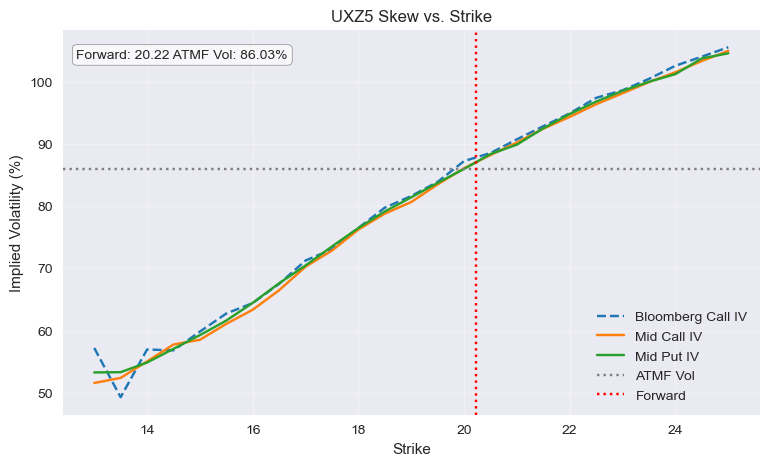

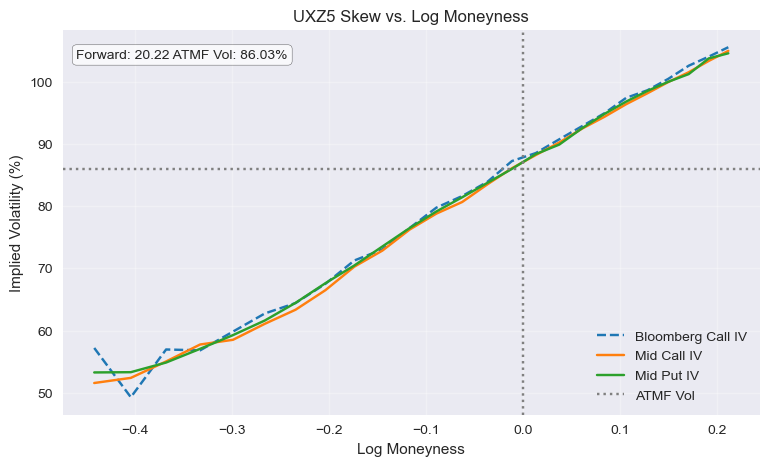

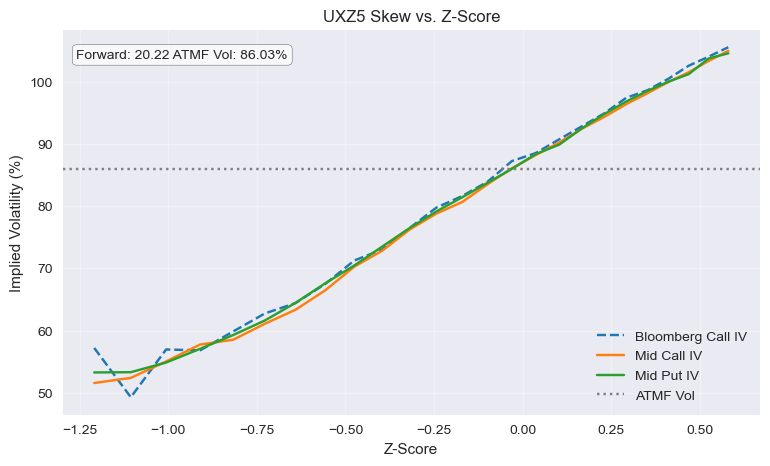

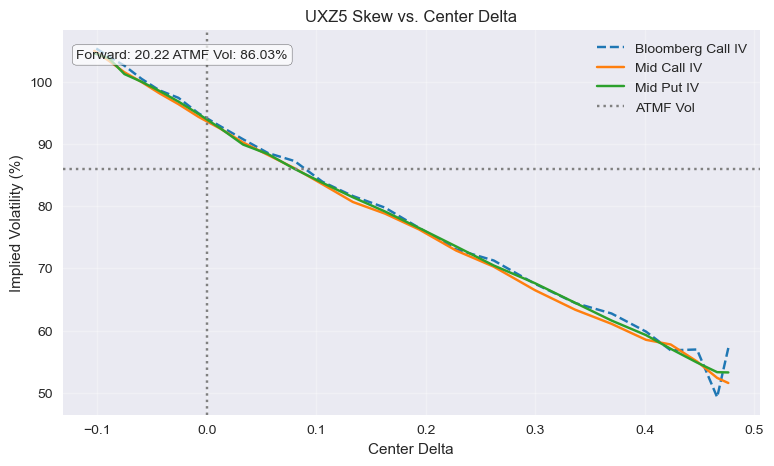

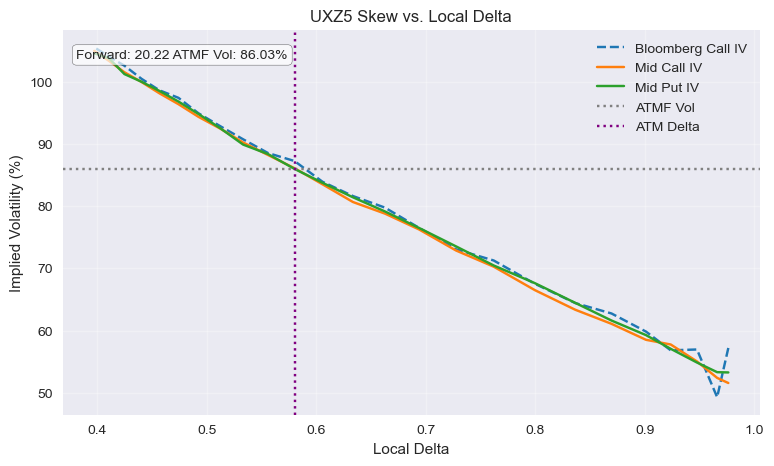

,Metric,Value
0,Forward (Parity Avg),21.051591
1,ATMF Vol,0.771794
2,ATM Call Delta,0.576249


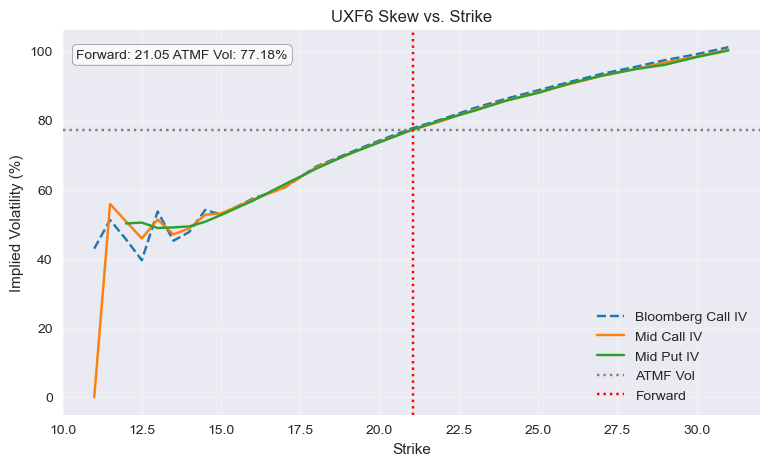

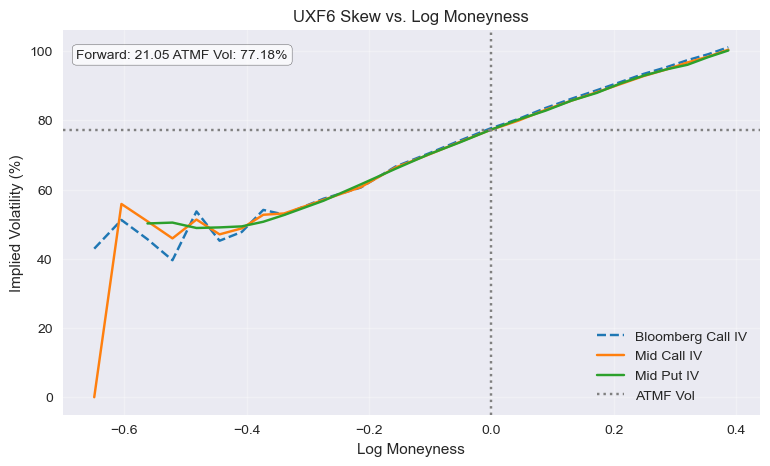

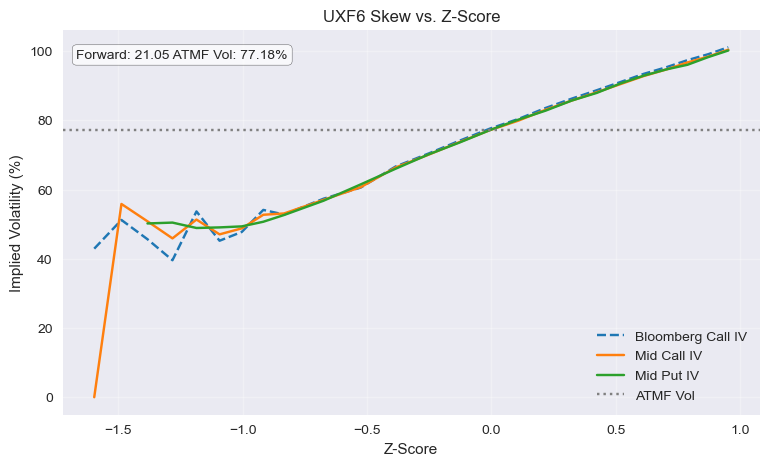

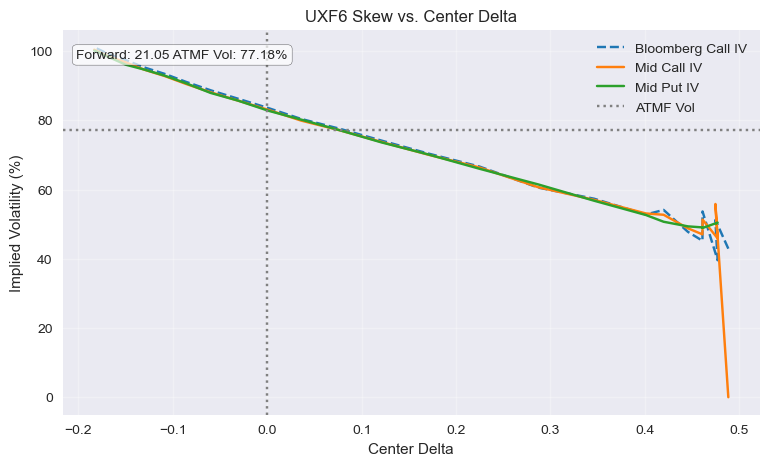

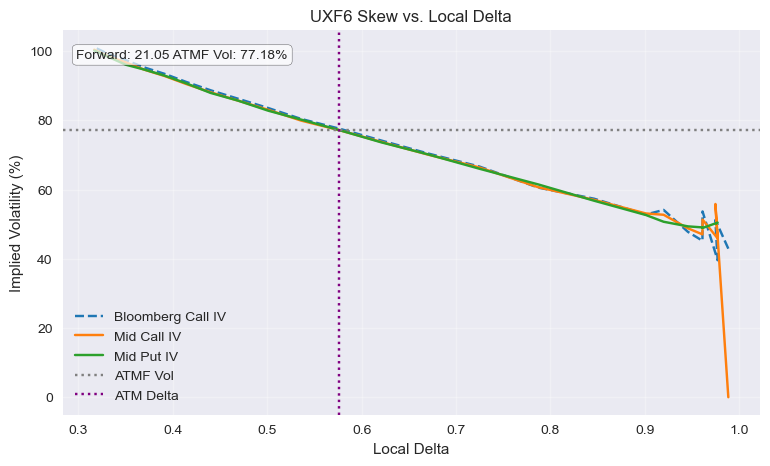

In [21]:

axis_config = [
    ('Strike', 'Strike'),
    ('Log Moneyness', 'Log Moneyness'),
    ('Z-Score', 'Z-Score'),
    ('Center Delta', 'Center Delta'),
    ('Local Delta', 'Local Delta'),
]

for expiry in ['UXZ5', 'UXF6']:
    grp = expiry_results[expiry].sort_values('Strike').copy()
    rate = grp['r'].iloc[0]
    tenor = grp['T'].iloc[0]
    forward_level = grp['Forward Level'].iloc[0]
    atmf_vol = grp['ATMFVol'].iloc[0]
    atm_delta = grp['ATM Call Delta'].iloc[0]

    display(pd.DataFrame({'Metric': ['Forward (Parity Avg)', 'ATMF Vol', 'ATM Call Delta'],
                            'Value': [forward_level, atmf_vol, atm_delta]}))

    for axis_label, axis_col in axis_config:
        fig, ax = plt.subplots(figsize=(9, 5))
        x = grp[axis_col]
        ax.plot(x, grp['Bloomberg Call IV'] * 100, label='Bloomberg Call IV', linestyle='--', color='tab:blue')
        ax.plot(x, grp['Mid Call IV'] * 100, label='Mid Call IV', color='tab:orange')
        ax.plot(x, grp['Mid Put IV'] * 100, label='Mid Put IV', color='tab:green')
        ax.axhline(atmf_vol * 100, color='gray', linestyle=':', label='ATMF Vol')
        if axis_col in ['Log Moneyness', 'Center Delta']:
            ax.axvline(0.0, color='gray', linestyle=':')
        if axis_col == 'Strike':
            ax.axvline(forward_level, color='red', linestyle=':', label='Forward')
        if axis_col == 'Local Delta':
            ax.axvline(atm_delta, color='purple', linestyle=':', label='ATM Delta')
        ax.set_title(f"{expiry} Skew vs. {axis_label}")
        ax.set_xlabel(axis_label)
        ax.set_ylabel('Implied Volatility (%)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.annotate(f"Forward: {forward_level:.2f} ATMF Vol: {atmf_vol:.2%}",
                            xy=(0.02, 0.95), xycoords='axes fraction', ha='left', va='top',
                            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        plt.show()



### Skew Interpretation

- **UXZ5:** The near-dated expiry shows pronounced downside skew, with implied volatility rising as strikes fall (negative log-moneyness) and put deltas increase in magnitude. The mid-derived volatilities sit slightly below Bloomberg levels around the forward but converge in the wings, suggesting tight mid quotes near the money.
- **UXF6:** The longer expiry exhibits a flatter skew through the center delta axis, though downside strikes still command higher volatilities. Mid-call and mid-put volatilities align closely except deep OTM puts, highlighting wider put spreads in the back month.

In [23]:

comparison = []
for expiry, grp in expiry_results.items():
    comparison.append({
        'Expiry': expiry,
        'Forward (Parity Avg)': grp['Forward Level'].iloc[0],
        'Future Reference': grp['Future'].iloc[0],
        'ATMF Vol': grp['ATMFVol'].iloc[0],
        'ATM Call Delta': grp['ATM Call Delta'].iloc[0]
    })
summary_table = pd.DataFrame(comparison)
summary_table


,Expiry,Forward (Parity Avg),Future Reference,ATMF Vol,ATM Call Delta
0,UXF6,21.051591,21.08,0.771794,0.576249
1,UXZ5,20.223022,20.26,0.860276,0.580251


The parity-derived forwards track the quoted futures within a few basis points for both expiries, validating the time-to-expiry alignment with the 13 October 2025 valuation date. UXZ5 carries the lower forward level and a higher ATMF volatility, reflecting nearer-term event risk and a steeper downside skew. UXF6 forwards sit higher with slightly lower ATMF volatility, and its skew profile is comparatively muted, indicating calmer expectations further along the curve.